In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
%cd '/content/drive/MyDrive/Colab Notebooks/deepnoid'

/content/drive/MyDrive/Colab Notebooks/deepnoid


In [10]:
!pip install xmltodict

In [11]:
import os
import pandas as pd
from glob import glob
import cv2
import numpy as np
import xmltodict as xmd
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from tqdm import tqdm

# Mapping from class names in XML to integers
class_mapping = {
    'Gun': 1,
    'Knife': 2,
    'Pliers': 3,
    'Scissors': 4,
    'Wrench': 5
}

# Function to create DataFrame
def load_from_directory(path):
    if os.path.isfile(path+'/annot.csv'):
        df = pd.read_csv(path+'/annot.csv')
        print(f"Loaded {path+'/annot.csv'}")
    else:
        df = pd.DataFrame(columns=['img', 'xml'])
        flist = glob(path+'/*.jpg')

        for i, img in tqdm(enumerate(flist), total=len(flist), desc=f'Loading data from {path}...'):
            xml = img[:-3] + 'xml'
            df.loc[i] = [img, xml]

        df.to_csv(path+'/annot.csv', index=False)

    return df

train_df = load_from_directory('./ugku-2/train')
valid_df = load_from_directory('./ugku-2/valid')
test_df  = load_from_directory('./ugku-2/test')

# Dataset class
class Data_Structure(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.image_ids = self.dataframe.index

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.dataframe.index[idx]
        fname, xml = self.dataframe.loc[idx]

        # Load image using OpenCV
        image = cv2.imread(fname, cv2.IMREAD_COLOR)[:,:,::-1].copy()
        image = cv2.resize(image, (512, 512), cv2.INTER_LINEAR) / 255.0

        # Load and parse XML annotation
        with open(xml, 'r') as f:
            annot = xmd.parse(f.read())['annotation']

        if 'object' not in annot:
            # Skip this image if no objects are annotated
            return self.__getitem__((idx + 1) % len(self))

        width, height = int(annot['size']['width']), int(annot['size']['height'])

        # Initialize lists for boxes and labels
        boxes = []
        labels = []

        # Check if there are multiple objects
        objects = annot['object']
        if isinstance(objects, list):
            for obj in objects:
                class_name = obj['name']
                if class_name in class_mapping:
                    object_class = class_mapping[class_name]
                    xmin, xmax, ymin, ymax = [int(obj['bndbox'][value]) for value in obj['bndbox']]
                    boxes.append([xmin, ymin, xmax, ymax])
                    labels.append(object_class)
                else:
                    print(f"Warning: Class name {class_name} not found in class_mapping")
        else:
            class_name = objects['name']
            if class_name in class_mapping:
                object_class = class_mapping[class_name]
                xmin, xmax, ymin, ymax = [int(objects['bndbox'][value]) for value in objects['bndbox']]
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(object_class)
            else:
                print(f"Warning: Class name {class_name} not found in class_mapping")

        # Convert lists to numpy arrays and normalize coordinates
        boxes = np.array(boxes, dtype=np.float32)
        if boxes.ndim == 1:  # If only one box, reshape it to 2D array
            boxes = boxes.reshape(-1, 4)
        boxes[:, ::2] = boxes[:, ::2] / width * 512
        boxes[:, 1::2] = boxes[:, 1::2] / height * 512

        # Calculate area of each bounding box
        areas = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

        # Create target dictionary for training
        target = {
            'image_id': torch.as_tensor(image_id),
            'boxes': torch.from_numpy(boxes),
            'labels': torch.as_tensor(labels),
            'area': torch.as_tensor(areas),
            'iscrowd': torch.zeros((len(boxes),), dtype=torch.int64)
        }

        return (
            torch.from_numpy(image).float().permute(2, 0, 1),
            target
        )


Loaded ./ugku-2/train/annot.csv
Loaded ./ugku-2/valid/annot.csv
Loaded ./ugku-2/test/annot.csv


In [ ]:
# Create datasets
train_dataset = Data_Structure(train_df)
valid_dataset = Data_Structure(valid_df)
test_dataset = Data_Structure(test_df)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

In [12]:
# Load pre-trained Faster R-CNN model and define the number of classes
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 6  # Including background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
# Set device for training
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Optimizer settings
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [14]:
# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    i = 0
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Compute loss
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Zero gradients, backpropagation, and optimizer step
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # Print loss every 10 iterations
        if i % 10 == 0:
            print(f"Epoch: {epoch}, Iteration: {i}, Loss: {losses.item()}")
        i += 1

Epoch: 0, Iteration: 0, Loss: 2.0384907722473145
Epoch: 0, Iteration: 10, Loss: 0.48637476563453674
Epoch: 0, Iteration: 20, Loss: 0.4620750844478607
Epoch: 0, Iteration: 30, Loss: 0.4527922570705414
Epoch: 0, Iteration: 40, Loss: 0.5286644697189331
Epoch: 0, Iteration: 50, Loss: 0.43085432052612305
Epoch: 0, Iteration: 60, Loss: 0.35591641068458557
Epoch: 0, Iteration: 70, Loss: 0.31459492444992065
Epoch: 0, Iteration: 80, Loss: 0.44620630145072937
Epoch: 0, Iteration: 90, Loss: 0.3189648985862732
Epoch: 0, Iteration: 100, Loss: 0.3696136474609375
Epoch: 0, Iteration: 110, Loss: 0.3156341314315796
Epoch: 0, Iteration: 120, Loss: 0.3619820773601532
Epoch: 0, Iteration: 130, Loss: 0.448768675327301
Epoch: 0, Iteration: 140, Loss: 0.5895609259605408
Epoch: 0, Iteration: 150, Loss: 0.4327142834663391
Epoch: 0, Iteration: 160, Loss: 0.5572279095649719
Epoch: 0, Iteration: 170, Loss: 0.5650727152824402
Epoch: 0, Iteration: 180, Loss: 0.31166109442710876
Epoch: 0, Iteration: 190, Loss: 0.256

In [16]:
# from google.colab import drive
# drive.mount('/content/drive')

In [17]:
import os
print(os.getcwd())

/content/drive/MyDrive/Colab Notebooks/deepnoid


In [18]:
torch.save(model.state_dict(), f'./detention_model.pth')


In [19]:
  # 검증 데이터에 대해 평가
model.eval()
with torch.no_grad():
    for images, targets in valid_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        outputs = model(images)
        # 결과를 확인하고 성능을 평가합니다.


In [20]:
# 테스트 데이터에 대해 모델 평가
model.eval()
with torch.no_grad():
    for images, targets in test_loader:
        images = list(img.to(device) for img in images)
        outputs = model(images)
        # 결과를 확인하고 성능을 평가합니다.

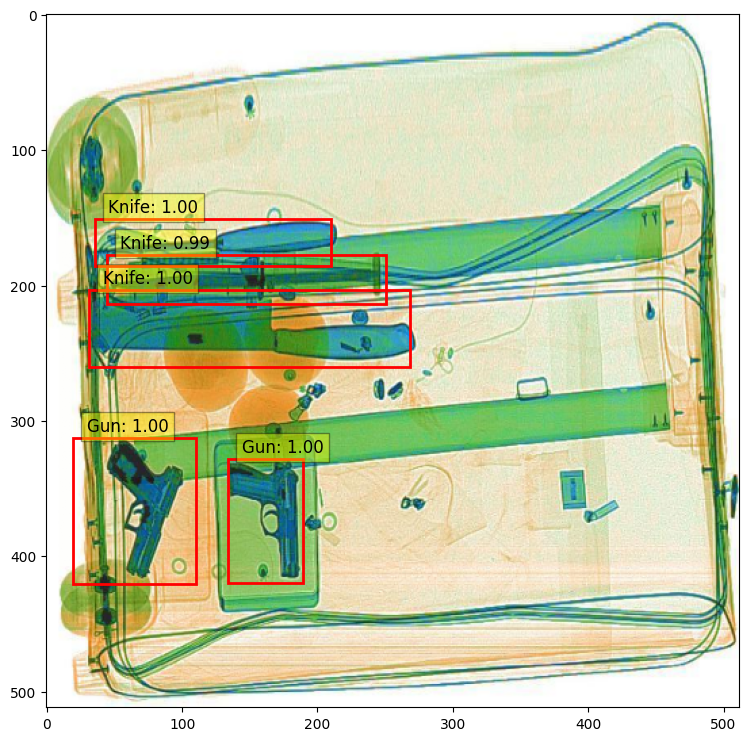

In [21]:
import matplotlib.pyplot as plt
class_names = {v: k for k, v in class_mapping.items()}

def predict_and_visualize(model, test_loader, device):
    model.eval()
    with torch.no_grad():
        for images, _ in test_loader:
            image = images[1].to(device)  # 첫 번째 이미지만 사용
            output = model([image])[0]

            image = image.permute(1, 2, 0).cpu().numpy()
            boxes = output['boxes'].cpu().detach().numpy()
            labels = output['labels'].cpu().detach().numpy()
            scores = output['scores'].cpu().detach().numpy()

            fig, ax = plt.subplots(1, figsize=(12, 9))
            ax.imshow(image)

            for box, label, score in zip(boxes, labels, scores):
                if score > 0.8:  # 신뢰도가 0.5 이상인 경우만 시각화
                    xmin, ymin, xmax, ymax = box
                    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                         fill=False, color='red', linewidth=2)
                    ax.add_patch(rect)
                    ax.text(xmin+10, ymin-5, f'{class_names[label]}: {score:.2f}',
                            bbox=dict(facecolor='yellow', alpha=0.4), fontsize=12, color='black')

            plt.show()
            break  # 첫 번째 배치만 사용

# 테스트 이미지 예측 및 시각화
predict_and_visualize(model, test_loader, device)